# Variational Autoencoder (VAE) to generate handwritten digits
* Author: Johannes Maucher - adapted from [keras autoencoder tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).
* Last Update: 10.12.2021
* Reference: [D.P. Kingma, M. Welling: Autoencoder Variational Bayes](https://arxiv.org/abs/1312.6114)

## Autoencoder

An autoencoder consists of an encoder- and a decoder-module. The encoder maps each input $\mathbf{x}$ to a latent representation $\mathbf{y}$, such that the decoder network is able to calculate a reconstruction $\mathbf{z}$ from $\mathbf{y}$, whereby $\mathbf{z}$ must be as close as possible to the input $\mathbf{x}$. The weights of the encoder- and decoder- module are learned by minimizing a loss-function, which measures the difference between the reconstruction $\mathbf{z}$ and the original $\mathbf{x}$. For this, standard gradient descent supervised learning algorithms, such as backpropagation can be applied. Even though the inputs must not be labeled (the target ist the input itself)! 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/autoencoder.png" width="450" class="center">

Usually the latent representation $\mathbf{y}$ is much smaller, than the original $\mathbf{x}$ and its reconstruction $\mathbf{z}$. Hence, the entire process realizes a standard lossy compression, such as e.g. jpeg-encoding of images.

After training an autoencoder, all inputs, which are similar to inputs seen in the training phase, will be reconstructed well. However, inputs, which are totally different from the training-samples won't be reconstructed well.  

For example, if the autoencoder has been trained with many images from rabbits and geese, these two types of animals will be reconstructed well, but if no elephants has been in the training data, the trained network won't be able to reconstruct elephants sufficiently. 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/autoencoderGans.png" width="450" class="center">

Two import application categories of autoencoders are:
* **Representation Learning** The latent representation $\mathbf{y}$ can be considered to be a meaningful and efficient representation of the input $\mathbf{x}$. This compressed representation contains all relevant information, since otherwise the original could not be reconstructed sufficiently.
* **Anomaly Detection**: The autoencoder is trained only with normal cases. In the inference phase normal cases at the input yield a small error between the input and its reconstruction. However, non-normal cases can not be reconstructed well. Hence, a high reconstruction error is an indicator for anomalies. 

## Variational Autoencoder
An autoencoder, as shortly described above, is not a generative model. It just tries to reconstruct the input, but it is not able to generate new data, e.g. new rabbit images or new geese images. This is where the **Variational Autoencoder (VAE)** comes in. A variational autoencoder is a generative model. A VAE, which has been trained with rabbit and geese-images is able to generate new rabbit- and geese images. A VAE, which has been trained with handwritten digit images is able to write new handwritten digits, etc. 

In general, if the probability distribution of one or multiple random variable(s) is known, then new samples, which arise from this distribution can be generated. For example, if the parameters *mean* and *standard-deviation* of a Gaussian-distributed random variable are known, then new samples can be generated, which correspond to this distribution. 

Based on this concept, a standard autoencoder can be modified to a generative model - the Variational Autoencoder - as follows: Instead of mapping the input $\mathbf{x}$ to a latent representation $\mathbf{y}$, the Encoder modul maps the input to a probability distribution. More concrete: A type of probability distribution (e.g. a Gaussian Normal Distribution) is presumed, and the output of the encoder are the concrete parameters of this distribution (e.g. *mean* and *standard deviation* for Gaussian distribution type). Then a concrete sample is generated from this distribution. This sample constitutes the input to the decoder.

The weights of the encoder and decoder-module are learned such that the output of the decoder is as close as possible to input - like in the case of an autoencoder, but now with the new process in the latent layer: parameter estimation and sampling.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/variationalAutoencoder.png" width="550" class="center">
  

## Implementation of Variational Autoencoder

In [1]:
#!pip install keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow.compat.v1.keras.backend as K # see https://stackoverflow.com/questions/61056781/typeerror-tensor-is-unhashable-instead-use-tensor-ref-as-the-key-in-keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras import losses
from keras.utils.vis_utils import plot_model

ImportError: dlopen(/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/_pywrap_tfe.so, 0x0002): Library not loaded: @rpath/_pywrap_tensorflow_internal.so
  Referenced from: /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/_pywrap_tfe.so
  Reason: tried: '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_x86_64/_U_S_Stensorflow_Spython_C_Upywrap_Utfe.so___Utensorflow/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_x86_64/_U_S_Stensorflow_Spython_C_Upywrap_Utensorflow_Uinternal_Umacos___Utensorflow_Spython/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_x86_64/_U_S_Stensorflow_Spython_C_Upywrap_Utfe.so___Utensorflow/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_x86_64/_U_S_Stensorflow_Spython_C_Upywrap_Utensorflow_Uinternal_Umacos___Utensorflow_Spython/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/bin/../lib/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/bin/../lib/_pywrap_tensorflow_internal.so' (no such file), '/usr/local/lib/_pywrap_tensorflow_internal.so' (no such file), '/usr/lib/_pywrap_tensorflow_internal.so' (no such file)

In [6]:
from os import environ
environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
environ["CUDA_VISIBLE_DEVICES"]="0"

In [7]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

### Define Architecture
#### Encoder Model

In [8]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

Note, that the encoder outputs are interpreted to be the **values** and the **logarithmic variance** values.

In [9]:
encoderModel=Model(inputs=x, outputs=[z_mean, z_log_var])

In [10]:
encoderModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            514         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense[0][0]                      
Total params: 201,988
Trainable params: 201,988
Non-trainable params: 0
______________________

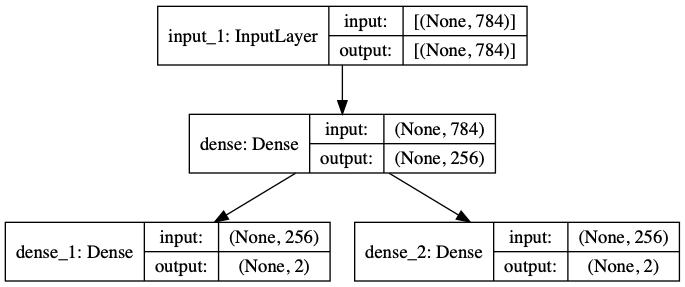

In [11]:
plot_model(encoderModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Sampling
Define function for sampling from a Gaussian Distribution:

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In the sampling function defined above, `epsilon` is an array of samples from a Gaussian Normal Distribution with mean 0 and standard-deviation 1. In order to transform this sample into a sample with mean $\mu$ and variance $\sigma^2$, epsilon must be multiplied with the standard-deviation $\sigma$ and added to mean $\mu$. Since we do not have $\sigma$ but only $t=\log(\sigma^2)$
Multiplication  with $\sigma$ is the same as multiplication with $e^{t/2}$.     

Implementation of the sampling function, as defined above, as a Keras layer:

In [13]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#### Decoder Model

In [14]:
#instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

#### End-to-End Autoencoder

In [18]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            514         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense[0][0]                      
____________________________________________________________________________________________

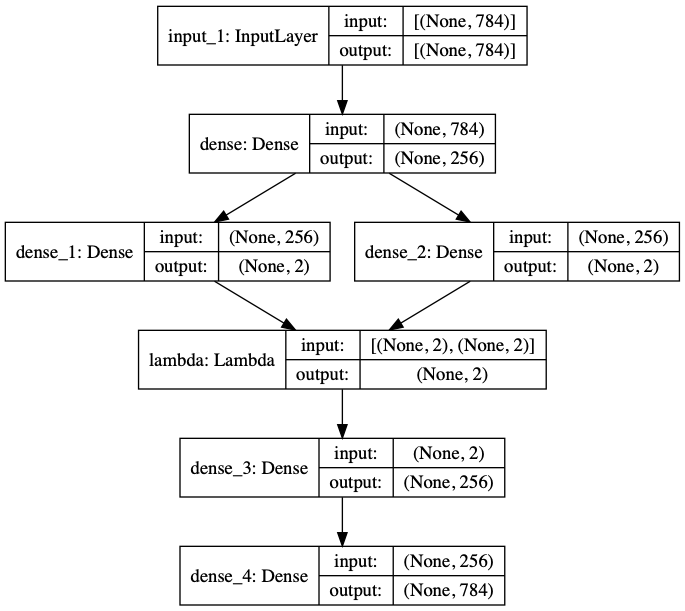

In [19]:
plot_model(vae, to_file='vae_plot.png', show_shapes=True, show_layer_names=True)

### Define Layer for Custom Loss

The parameters of the model are trained by minizing a loss function, which consists of two terms: 
* a **reconstruction loss** forcing the decoded samples to match the initial inputs. For this reconstruction loss *binary crossentropy* is applied.
* the KL divergence between the learned latent distribution and the prior distribution. This term acts as a **regularization term**. 

In order to implement this custom loss function a corresponding layer is defined as follows:

In [30]:
class KLDivergenceLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean) # reconstruction loss
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # regularisation term
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [21]:
y = KLDivergenceLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

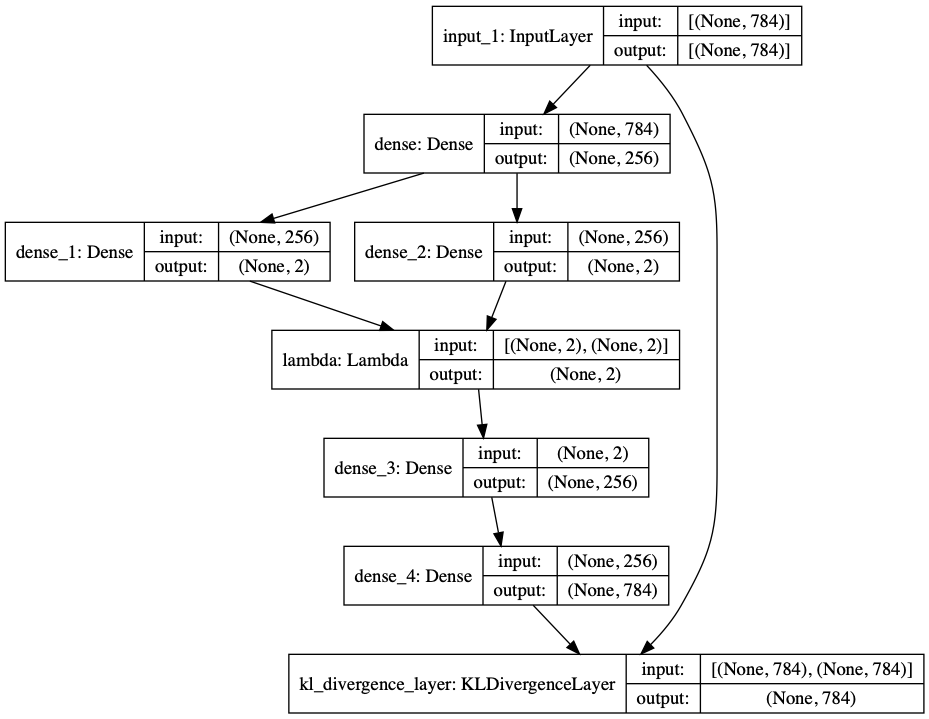

In [22]:
plot_model(vae, to_file='vae_kl_plot.png', show_shapes=True, show_layer_names=True)

### Training VAE

In [23]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [24]:
hist=vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None),
        verbose=False)

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


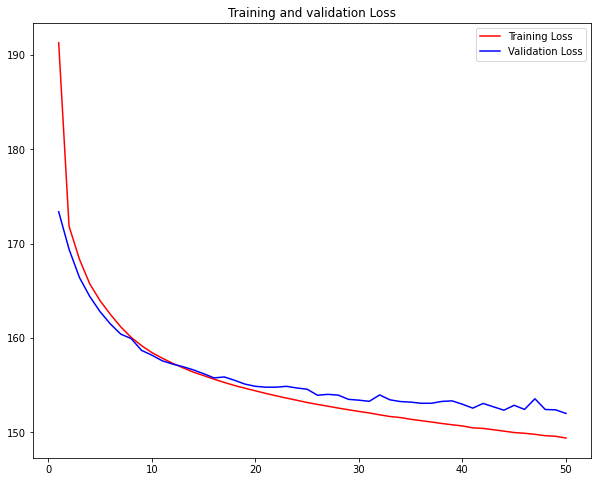

In [25]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
max_val_acc=np.max(val_loss)
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

### Project Inputs to latent space

In [26]:
encoder = Model(x, z_mean)

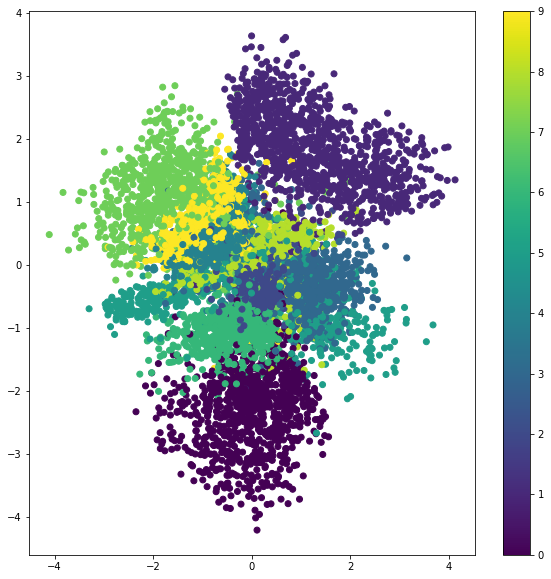

In [27]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded,_ = encoderModel.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

### Build Digit Generator

Next, a digit generator, which samples from the learned distribution is build.

In [28]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

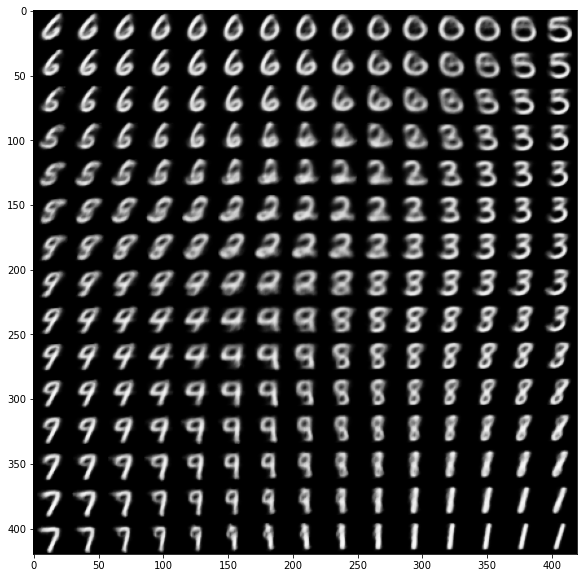

In [29]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()